In [364]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm
from pandas import read_csv

## Simulation and code properties

In [366]:
#Conversion in IU
G_p = 6.67259e-8 #G in cgs
M_phy = 1.9891e33 #solar mass in g
R_sun = 6.9598e10 #solar radius in cm 
year = 3.14159e7 #year in seconds
ly = 9.463e17 #light year in cm
parsec = 3.086e18 #parsec in cm
AU = 1.496e13 #astronomical unit in cm

def v_IU(v_p, M_p=M_phy, r_p=AU):
    return np.sqrt(r_p / (G_p * M_p)) * v_p

def t_IU(t_p, M_p=M_phy, r_p=AU):
    return t_p / (np.sqrt(r_p / (G_p * M_p)) * r_p)

r_phy = parsec
M_phy = M_phy
t_iu_phy = t_IU(year, M_phy, r_phy) #1 yr is 6.251839 IU
v_iu_cgs = v_IU(1, M_phy, r_phy) #1 cm/s is 3.357e-7 IU

In [367]:
N = 10000 #Number of particles
M = 10000 #Total mass in 1e6 solar masses
b = 1 #Total radius in parsec
m_i = M / N #Particle mass in solar masses
mass_populations = False #True to use the simulation with two mass populations
generate = False #True to write the generated distribution to file

#Relative path of the generated file
path = "PR_N" + str(N) + "_M" + str(int(M)) + "_b" + str(b)

In [368]:
#Softening parameter epsilon
vol = 4/3 * np.pi * b**3
eps = 0.5 * (vol / N)**(1/3)

#Print command to run the Treecode
print('./treecode in="../Project/Input/' + path + '.in"' + 
      ' out="../Project/Output/' + path + '.out"' +
      ' dtime=1 eps=' + str(eps) + ' theta=0.1 tstop=0.01 dtout=0.01' + 
      ' > "../Project/Logs/' + path + '_log"')

./treecode in="../Project/Input/PR_N10000_M10000_b1.in" out="../Project/Output/PR_N10000_M10000_b1.out" dtime=1 eps=0.03741101926818245 theta=0.1 tstop=0.01 dtout=0.01 > "../Project/Logs/PR_N10000_M10000_b1_log"


## Generate simulation initial conditions

In [370]:
#Function to generate a distribution of particles to input in the Treecode
def GenInput(N, m_i, b, to_file=False):
    #Initial masses    
    if mass_populations:
        m1_N = int(0.99*N)
        m1 = M / (1.09 * N)
        m2 = 10 * m1
        masses = np.concatenate((np.ones(m1_N) * m1, np.ones(N - m1_N) * m2)) 
        np.random.shuffle(masses)
        
    else:
        masses = np.ones(N) * m_i
    
    #Cumulative distributions
    P_r = np.random.uniform(0, 1, N) 
    P_phi = np.random.uniform(0, 1, N)
    P_theta = np.random.uniform(0, 1, N)
    
    #Draw spherical coordinates based on their PDF using the inverse cumulative
    r = b * (P_r**(-2/3) - 1)**(-1/2)
    phi = 2 * np.pi * P_phi
    theta = np.arccos(1 - 2 * P_theta)
    
    #Convert in cartesian coordinates
    x_0 = r * np.cos(phi) * np.sin(theta)
    y_0 = r * np.sin(phi) * np.sin(theta)
    z_0 = r * np.cos(theta) 
    
    #CM position
    CM_x = np.sum(masses * x_0) / M
    CM_y = np.sum(masses * y_0) / M
    CM_z = np.sum(masses * z_0) / M
    
    #Positions of the particles in the CM frame
    x_CM = x_0 - CM_x
    y_CM = y_0 - CM_y
    z_CM = z_0 - CM_z
    
    r_CM = np.sqrt(x_CM**2 + y_CM**2 + z_CM**2)
    
    #Initial velocities
    psi_IU = -M / np.sqrt(r_CM**2 + b**2)
    
    norm_q = quad(lambda q: (1 - q**2)**(7/2) * q**2, 0, 1)[0]
    f = lambda q: (1 - q**2)**(7/2) * q**2 / norm_q
    max_f = np.max(f(np.linspace(0, 1, N)))
    
    q_samples = []
    
    while len(q_samples) < N:
        q_rand = np.random.uniform(0, 1)
        y = np.random.uniform(0, max_f)
        
        if y <= f(q_rand):
            q_samples.append(q_rand)
            
    v = np.array(q_samples) * np.sqrt(2 * -psi_IU)
    
    v_phi = 2 * np.pi * np.random.uniform(0, 1, N)
    v_theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))

    vx_0 = v * np.cos(v_phi) * np.sin(v_theta)
    vy_0 = v * np.sin(v_phi) * np.sin(v_theta)
    vz_0 = v * np.cos(v_theta)  
        
    #Write to file
    if to_file:
        file_path = "Input/" + path + ".in"
        
        with open(file_path, "w") as i_file:
            i_file.write(str(N) + "\n3\n0\n")
            
            for i in tqdm(range(N)):
                # i_file.write(str(m_i) + "\n") 
                i_file.write(str(masses[i]) + "\n")
                
            for i in tqdm(range(N)):
                i_file.write(str(x_0[i]) + " " + str(y_0[i]) + " " + str(z_0[i]) + "\n")
            
            for i in tqdm(range(N)):    
                i_file.write(str(vx_0[i]) + " " + str(vy_0[i]) + " " + str(vz_0[i]) + "\n")
        
    return x_0, y_0, z_0, vx_0, vy_0, vz_0, r, phi, theta, x_CM, y_CM, z_CM, r_CM, masses


In [371]:
x_0, y_0, z_0, vx_0, vy_0, vz_0, r, phi, theta, x_CM, y_CM, z_CM, r_CM, masses = GenInput(N, m_i, b, generate)

## Check consistency of initial conditions

### Theoretical timescales

In [374]:
#Compute the dynamical time in years
density_0 = M * M_phy / (4/3 * np.pi * (b * r_phy)**3)
t_dyn = np.sqrt(3 * np.pi / (16 * G_p * density_0)) / year

#Compute relaxation timescale
n_rel = N / (8 * np.log(N))
t_cross = np.median(r) / np.median(np.sqrt(vx_0**2 + vy_0**2 + vz_0**2))
t_rel = t_cross * n_rel

print("Crossing time: t_cross =" + f"{t_cross / t_iu_phy: .3e}" + " yr =" + f"{t_cross: .3e}" + " IU")
print("Relaxation time: t_rel =" + f"{t_rel / t_iu_phy: .3e}" + " yr =" + f"{t_rel: .3e}" + " IU")
print("Dynamical time: t_dyn =" + f"{t_dyn: .3e}" + " yr =" + f"{t_dyn * t_iu_phy: .3e}" + " IU")
print("Initial mean density = " + f"{density_0: .3e}" + " g cm^-3")

Crossing time: t_cross = 4.034e+05 yr = 2.693e-02 IU
Relaxation time: t_rel = 5.474e+07 yr = 3.655e+00 IU
Dynamical time: t_dyn = 2.353e+05 yr = 1.571e-02 IU
Initial mean density =  1.616e-19 g cm^-3


### Visualize the generated distribution

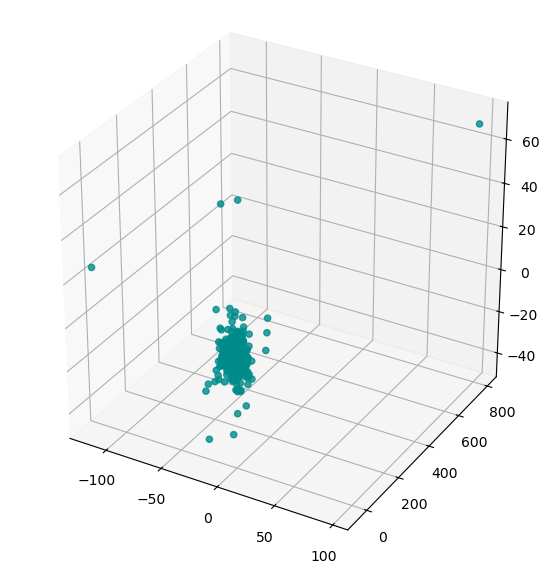

In [376]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.set_aspect("equal")
ax.scatter(x_0, y_0, z_0, alpha=0.8, color="darkcyan")

Text(0.5, 0.93, 'Spherical coordinates distributions')

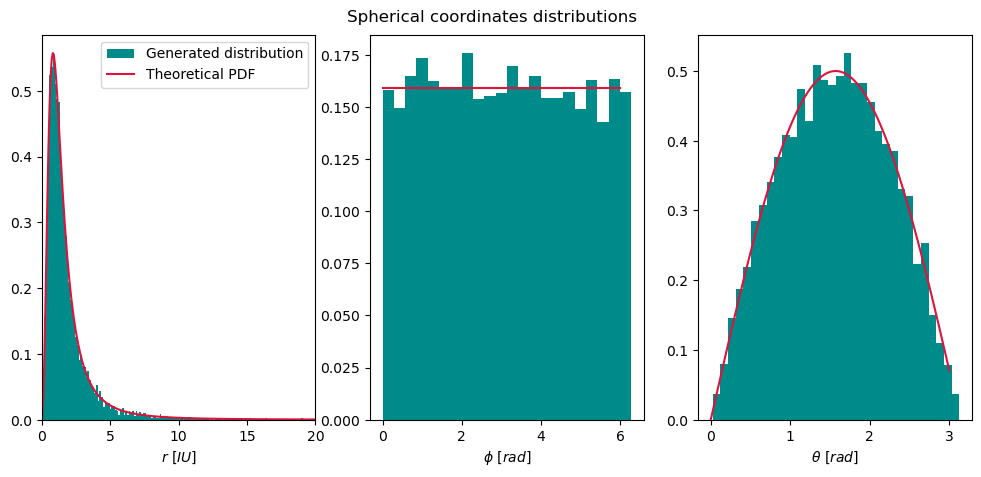

In [377]:
#Plot the spherical coordinates distributions
coordr_range = np.linspace(0, 80, 1000)
coordp_range = np.linspace(0, 6, 100)
coordt_range = np.linspace(0, 3, 100)

r_pdf = lambda r: (3/(4 * np.pi * b**3) * (1 + r**2 / b**2)**(-5/2)) * r**2
r_norm = quad(r_pdf, 0, np.inf)[0]

fig_sp, ax_sp = plt.subplots(1, 3, figsize=(12, 5))

ax_sp[0].hist(r, bins="fd", color="darkcyan", density=True, label="Generated distribution")
ax_sp[0].set_xlabel("$r\ [IU]$")
ax_sp[0].plot(coordr_range, r_pdf(coordr_range) / r_norm, color="crimson", label="Theoretical PDF")
ax_sp[0].set_xlim(0, 20)
ax_sp[0].legend()

ax_sp[1].hist(phi, bins="fd", color="darkcyan", density=True)
ax_sp[1].set_xlabel("$\phi\ [rad]$")
ax_sp[1].plot(coordp_range, np.ones(len(coordt_range)) * 1/(2 * np.pi), color="crimson")

ax_sp[2].hist(theta, bins="fd", color="darkcyan", density=True)
ax_sp[2].set_xlabel("$\\theta\ [rad]$")
ax_sp[2].plot(coordt_range, 0.5 * np.sin(coordt_range), color="crimson")

fig_sp.suptitle("Spherical coordinates distributions", y=0.93)

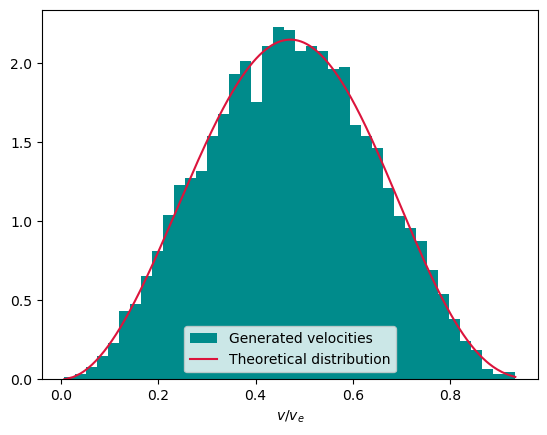

In [378]:
#Plot the velocity distribution
#Velocity modulus
v = np.sqrt(vx_0**2 + vy_0**2 + vz_0**2)

#Theoretical velocity distribution
norm_q = quad(lambda q: (1 - q**2)**(7/2) * q**2, 0, 1)[0]
v_d = lambda q: (1 - q**2)**(7/2) * q**2 / norm_q

#Escape velocity: v = q * v_e
v_e = np.sqrt(2 * M / np.sqrt(r_CM**2 + b**2)) 

plt.figure()
plt.hist(v / v_e, bins="fd", color="darkcyan", density=True, label="Generated velocities")
plt.plot(np.sort(v / v_e), v_d(np.sort(v / v_e)), color="crimson", label="Theoretical distribution")
plt.xlabel("$v / v_e$")
plt.legend()

Text(0, 0.5, 'V [IU]')

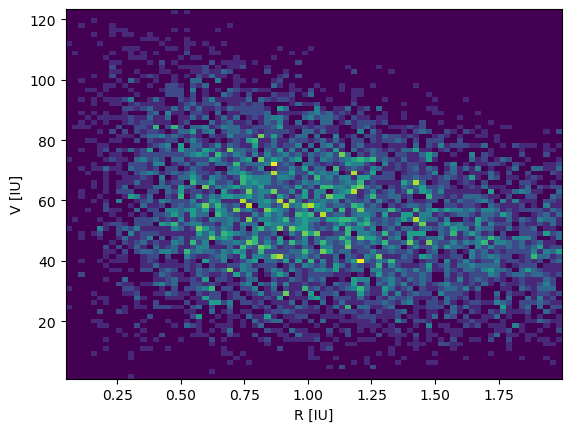

In [379]:
#Phase space visualization
#Show only particles that start close to the center
close_particles = r < 2 * b

plt.figure()
plt.hist2d(r[close_particles], v[close_particles], bins=80)
plt.xlabel("R [IU]", size=10)
plt.ylabel("V [IU]", size=10)   

### Density profile

In [381]:
#Function to divide the distribution in intervals
def DivideDistribution(rmin, rmax, r_grid_len, equal_volume=False):   
    if equal_volume:
        #Divide the sphere in volume elements, all with the same total volume
        volume = 4/3 * np.pi * rmax**3 / r_grid_len

        #Compute the radii of each volume element to form a grid of radii, up to an edge
        r_grid = np.zeros(r_grid_len)

        for i in range(r_grid_len - 1):
            r_grid[i + 1] = (3/4 / np.pi * volume + r_grid[i]**3)**(1/3)
            
        if r_grid[-1] < rmax:
            r_grid = np.append(r_grid, rmax)
            
    else:
        #Divide the sphere in volume elements, with constant radius intervals
        r_grid = np.linspace(rmin, rmax, r_grid_len)
            
        volume = 4/3 * np.pi * np.array([r_grid[i + 1]**3 - r_grid[i]**3 for i in range(len(r_grid) - 1)])

    return r_grid, volume

In [382]:
#Divide the distribution in radius intervals
r_grid, volume = DivideDistribution(0, 5 * b, 45, False)

#Compute the density in each radius interval and the Poisson error
masses_binned = np.histogram(r_CM, bins=r_grid, weights=masses)[0]
numbers_binned = np.histogram(r_CM, bins=r_grid)[0]

rho = masses_binned / volume * M_phy * r_phy**-3
rho_err = np.sqrt(numbers_binned) * np.mean(masses) / volume * M_phy * r_phy**-3

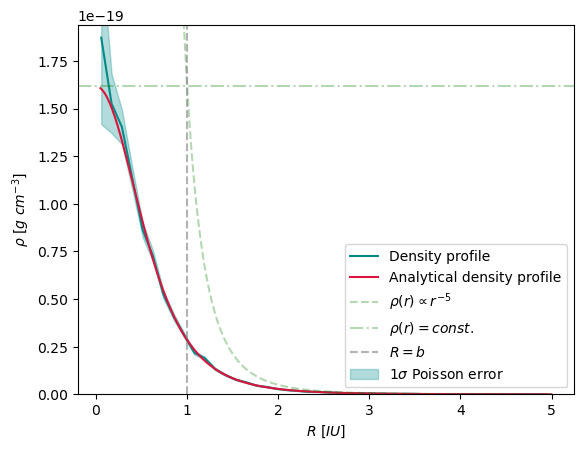

In [383]:
#Plot the density at each radius corresponding to the middle of a bin
#Theoretical density profile
r_range = np.arange(np.min(r), 5 * b, 0.01)
rho_th = lambda rad: 3 * M / (4 * np.pi* b**3) * (1 + rad**2/b**2)**(-5/2) * M_phy * r_phy**-3

#Center of every interval
bar_pos = np.diff(r_grid) / 2 + r_grid[:-1]

fig_rho, ax_rho = plt.subplots()
ax_rho.plot(bar_pos, rho, color="darkcyan", label="Density profile")
ax_rho.plot(r_range, rho_th(r_range), color="crimson", label="Analytical density profile")
ax_rho.plot(r_range, 3 * M / (4 * np.pi* b**-2) * r_range**-5 * M_phy * r_phy**-3, alpha=0.3, linestyle="--", color="green", label="$\\rho(r) \propto r^{-5}$")
ax_rho.axhline(3 * M / (4 * np.pi* b**3) * M_phy * r_phy**-3, alpha=0.3, linestyle="-.", color="green", label="$\\rho(r) = const.$")
ax_rho.axvline(b, alpha=0.6, color="grey", linestyle="--", label="$R = b$")
ax_rho.fill_between(bar_pos, 
                  rho - rho_err, 
                  rho + rho_err, alpha=0.3, color="darkcyan", label="$1\sigma$ Poisson error")
plt.xlabel("$R\ [IU]$")
plt.ylabel("$\\rho\ [g\ cm^{-3}]$")
plt.ylim(0, 1.2 * 3 * M / (4 * np.pi* b**3) * M_phy * r_phy**-3)
plt.legend()

### Potential profile

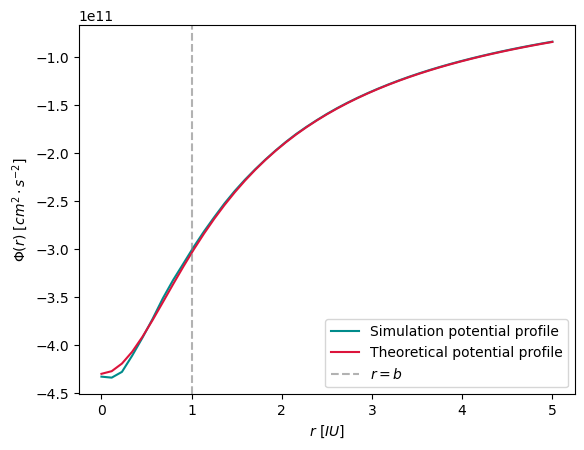

In [385]:
#Compute the potential profile
V = np.zeros(len(r_grid))

for rad in range(len(r_grid)):
    V[rad] = -G_p * m_i * M_phy * r_phy**-1 * np.sum(np.sqrt((x_0 - r_grid[rad])**2 + 
                                                    y_0**2 + z_0**2)**-1)
        
#Potential profile plot
#Theoretical profile
V_th = lambda r: -G_p * M * M_phy * r_phy**-1 * (r**2 + b**2)**(-1/2)
        
plt.figure()
plt.plot(r_grid, V, color="darkcyan", label="Simulation potential profile")
plt.plot(r_grid, V_th(r_grid), color="crimson", label="Theoretical potential profile")
plt.axvline(b, alpha=0.6, color="grey", linestyle="--", label="$r = b$")
plt.xlabel("$r\ [IU]$")
plt.ylabel("$\Phi (r)\ [cm^2 \cdot s^{-2}]$")
plt.legend()